#Bibliotecas
- **pyspark:** Esta biblioteca é a interface Python para o Apache Spark, um mecanismo de análise unificada para processamento de dados em larga escala. No seu código, ela é usada para realizar a Análise de Tópicos Latente de Dirichlet (LDA) nos textos das homilias.
- **nltk:** Significa Natural Language Toolkit. É uma biblioteca líder para trabalhar com dados de linguagem humana (texto e voz). No seu código, o NLTK é usado para baixar recursos linguísticos como o tokenizador ('punkt') e as stopwords ('stopwords').
- **beautifulsoup4:** Esta biblioteca é usada para web scraping. Ela ajuda a extrair dados de arquivos HTML e XML, analisando-os. No seu código, é usada para analisar o conteúdo das páginas da web do Vaticano e extrair os textos das homilias.
- **requests:** Esta biblioteca permite enviar solicitações HTTP para servidores web. No seu código, é usada para baixar as páginas web do Vaticano que contêm as homilias.
- **unidecode:** Esta biblioteca converte texto Unicode (como caracteres acentuados) em representações ASCII. No seu código, é usada para remover acentuação e caracteres especiais dos textos das homilias.
- **--quiet:** faz com que o pip imprima menos informações no console durante a instalação.

In [1]:
!pip install pyspark nltk beautifulsoup4 requests unidecode --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.8 MB/s eta 0:00:00


- Importa bibliotecas: Importa as bibliotecas requests, BeautifulSoup, re, time, unidecode e nltk.
- Baixa recursos do NLTK: Baixa os recursos 'punkt' e 'stopwords' do NLTK, que são necessários para o processamento de texto posterior (tokenização e remoção de stopwords).
- Define cabeçalho HTTP: Define um dicionário headers com um "User-Agent" para simular um navegador web ao fazer requisições HTTP.
- Define os anos a serem processados: Define um intervalo de anos (2013 a 2014, incluindo 2013, mas não 2015) na variável anos.
- Coleta links das homilias:
 - Itera sobre cada ano no intervalo definido.
 - Constrói a URL para a página de homilias daquele ano no site do Vaticano.
 - Faz uma requisição HTTP GET para a URL.
 - Se a requisição for bem-sucedida (código de status 200), utiliza BeautifulSoup para analisar o conteúdo HTML da página.
 - Procura por todos os links ( tags) na página.
 - Verifica se o href do link começa com '/content/francesco/pt/homilies/', contém 'documents' e termina com '.html'.
 - Se o link corresponder a esses critérios e ainda não estiver na lista links_homilias, ele é adicionado à lista.
 - Inclui uma pausa de 0.5 segundos entre as requisições para não sobrecarregar o servidor do Vaticano.
- Imprime o total de links encontrados: Exibe a quantidade total de links de homilias coletados.

In [2]:

import requests
from bs4 import BeautifulSoup
import re
import time
from unidecode import unidecode
import nltk

nltk.download('punkt')
nltk.download('stopwords')

headers = {
    "User-Agent": "Mozilla/5.0"
}

anos = range(2013, 2015)
links_homilias = []

for ano in anos:
    url_ano = f'https://www.vatican.va/content/francesco/pt/homilies/{ano}.html'
    response = requests.get(url_ano, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        for link in soup.find_all('a', href=True):
            href = link['href']
            if href.startswith('/content/francesco/pt/homilies/') and 'documents' in href and href.endswith('.html'):
                full_url = f'https://www.vatican.va{href}'
                if full_url not in links_homilias:
                    links_homilias.append(full_url)
    time.sleep(0.5)

print(f"Total de homilias encontradas: {len(links_homilias)}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total de homilias encontradas: 39


- Receber um URL como entrada: A função espera o URL de uma página individual de homilia.
- Fazer uma requisição HTTP: Tenta baixar o conteúdo da página usando a biblioteca requests e o cabeçalho definido anteriormente.
- Verificar o status da resposta: Se a requisição não for bem-sucedida (código de status diferente de 200), a função retorna uma string vazia e None para o ano.
- Analisar o conteúdo HTML: Se a requisição for bem-sucedida, utiliza BeautifulSoup para analisar o conteúdo HTML da página.
- Extrair o texto principal: Procura por uma div com a classe 'rounded', que aparentemente contém o texto principal da homilia. Dentro dessa div, encontra todos os parágrafos (<p> ou <font>) e junta o texto deles.
- Limpar o texto:
 - Remove acentuação e caracteres especiais usando unidecode.
 - Substitui múltiplos espaços em branco por um único espaço usando re.sub.
- Extrair o ano do URL: Tenta extrair o ano da homilia do próprio URL usando uma expressão regular.
- Retornar o texto limpo e o ano: Retorna o texto extraído e limpo da homilia, juntamente com o ano correspondente. Se o conteúdo principal não for encontrado, retorna uma string vazia e None.

In [3]:
def obter_homilia(url):
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "", None
    soup = BeautifulSoup(response.content, 'html.parser')
    conteudo = soup.select_one('div.rounded')
    if conteudo:
        paragrafos = conteudo.find_all(['p', 'font'])
        texto = ' '.join([p.get_text(separator=' ', strip=True) for p in paragrafos])
        texto = unidecode(texto)
        texto = re.sub(r'\s+', ' ', texto)

        match = re.search(r'/(\d{4})/', url)
        ano = int(match.group(1)) if match else None

        return texto.strip(), ano
    return "", None



- Importa bibliotecas: Importa as bibliotecas necessárias para baixar dados em paralelo (concurrent.futures) e as já usadas para requisições, parsing, etc. (requests, BeautifulSoup, re, time, unidecode).
- Define o cabeçalho HTTP: Define o headers para as requisições HTTP.
- Define os anos a serem processados: Define o intervalo de anos na variável anos.
- Coleta os links das homilias: Este bloco de código (que repete a lógica da célula 2) navega pelas páginas de homilias do Vaticano para os anos especificados e coleta os URLs de cada homilia individual. Embora redundante se a célula 2 já foi executada, ele garante que a lista links_homilias esteja populada com os URLs que serão baixados.
- Coleta os textos por ano (em paralelo):
 - Inicializa um dicionário vazio chamado textos_ano para armazenar as homilias, organizadas por ano.
 - Cria um concurrent.futures.ThreadPoolExecutor() para permitir o download das homilias em paralelo, acelerando o processo.
 - Usa executor.map(obter_homilia, links_homilias) para chamar a função obter_homilia (definida na célula 3) para cada URL na lista links_homilias. O uso de map com o executor executa essas chamadas em paralelo.
 - Itera sobre os resultados retornados pelas chamadas paralelas. Para cada resultado (que é uma tupla (texto, ano)), se o texto e o ano forem válidos, o texto é adicionado à lista correspondente ao ano no dicionário textos_ano.
- Visualiza o total de homilias por ano: Itera sobre o dicionário textos_ano e imprime a contagem de homilias coletadas para cada ano, confirmando que a coleta foi bem-sucedida para os anos especificados (como você confirmou com a saída "2013: 38 homilias", etc.).





In [4]:
import requests
from bs4 import BeautifulSoup
import re
import time
from unidecode import unidecode
import concurrent.futures

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

anos = range(2013, 2015)  # Ajuste os anos conforme necessário
links_homilias = []

# Coletar os links das homilias (Este bloco também pode ser redundante se a célula 2 já fez isso)
for ano in anos:
    url = f"https://www.vatican.va/content/francesco/pt/homilies/{ano}.html"
    resposta = requests.get(url, headers=headers)
    if resposta.status_code == 200:
        soup = BeautifulSoup(resposta.text, "html.parser")
        for link in soup.find_all("a", href=True):
            href = link["href"]
            if "/content/francesco/pt/homilies/" in href and href.endswith(".html"):
                full_url = "https://www.vatican.va" + href
                links_homilias.append(full_url)
    time.sleep(0.5)

# REMOVER A DEFINIÇÃO DA FUNÇÃO obter_homilia AQUI

# Coletar os textos por ano
textos_ano = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
    resultados = executor.map(obter_homilia, links_homilias) # AQUI A FUNÇÃO DEFINIDA NA CÉLULA 3 SERÁ CHAMADA
    for texto, ano in resultados:
        if texto and ano:
            textos_ano.setdefault(ano, []).append(texto)

# Visualizar o total de homilias por ano
for ano, lista in textos_ano.items():
    print(f"{ano}: {len(lista)} homilias")

2013: 38 homilias
2014: 40 homilias


- Importa bibliotecas Spark e outras necessárias:
 - SparkSession do pyspark.sql: Usada para criar e gerenciar a sessão Spark.
 - Tokenizer, CountVectorizer, LDA do pyspark.ml.feature e pyspark.ml.clustering: Componentes do Spark MLlib para processamento de texto e modelagem de tópicos.
 - col e Row do pyspark.sql.functions e pyspark.sql: Funções e estruturas de dados para trabalhar com DataFrames Spark.
- Define uma lista de Stopwords: Cria um conjunto (set) chamado stop_words contendo palavras comuns em português e alguns outros caracteres que você deseja remover dos textos antes da análise (palavras como 'a', 'o', 'de', etc., e também alguns termos específicos encontrados nos textos como 'comunicazione', 'copyright', etc.).
- Cria ou obtém a SparkSession: spark = SparkSession.builder.getOrCreate() inicializa uma sessão Spark. Se uma sessão já existir, ela a reutiliza; caso contrário, cria uma nova. O Spark é necessário para executar os algoritmos de processamento em larga escala.
- Define a função aplicar_lda: Esta é a função principal da célula e contém a lógica para aplicar o LDA a um conjunto de homilias de um determinado ano. Ela faz o seguinte:
 - Cria um DataFrame Spark: Transforma a lista de textos de homilias para um ano específico em um DataFrame Spark com uma coluna "texto".
 - Tokeniza o texto: Usa Tokenizer para dividir cada texto em palavras individuais.
 - Remove Stopwords: Usa StopWordsRemover para remover as palavras listadas no conjunto stop_words dos tokens.
 - Vectoriza os termos: Usa CountVectorizer para converter as palavras filtradas em vetores numéricos que representam a contagem de cada palavra. Isso é necessário como entrada para o LDA.
 - Aplica o LDA: Instancia o modelo LDA com k=2 (indicando que você deseja encontrar 2 tópicos) e um número máximo de iterações (maxIter=10). Em seguida, treina (fit) o modelo nos dados vetorizados.
 - Extrai e exibe os tópicos:
   - Usa modelo_lda.describeTopics(10) para obter os 10 termos mais importantes para cada tópico.
   - Mapeia os índices dos termos de volta para as palavras reais usando o vocabulário gerado pelo CountVectorizer.
   - Formata e imprime os termos mais relevantes para cada tópico para o ano em questão.
- Itera sobre os anos e aplica o LDA: Loop sobre os anos presentes no dicionário textos_ano (que foi populado na célula 4). Para cada ano, chama a função aplicar_lda, passando a lista de homilias daquele ano.

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import col
from pyspark.sql import Row

stop_words = set([
    'a', 'e', 'o', 'as', 'os', 'um', 'uma', 'de', 'do', 'da', 'das', 'dos', 'onde',
    'em', 'para', 'com', 'por', 'na', 'no', 'que', 'se', 'ao', 'aos', 'à', 'às', 'assim', 'quem',
    'como', 'mais', 'mas', 'nos', 'pelos', 'pelo', 'não', 'sim', 'foi', 'são', 'lhe', 'nas',
    'ser', 'esta', 'está', 'estavam', 'já', 'vai', 'vou', 'nós', 'eles', 'elas', 'lo',
    'eu', 'você', 'dele', 'dela', 'me', 'te', 'seu', 'sua', 'isso', 'tambem', 'cada', 'seja', 'nao', 'la',
    'comunicazione', 'copyright', 'libreria', 'cf', 'lc', 'mt', 'mc', 'jo', 'rm', 'hb', 'at', 'is', 'sl', 'ex',
    'dicastero', 'per', 'vaticana', 'editrice', ',', '.', ';', '!', '?', '-'
])

spark = SparkSession.builder.getOrCreate()

def aplicar_lda(homilias, ano):
    df = spark.createDataFrame([(t,) for t in homilias], ["texto"])
    tokenizer = Tokenizer(inputCol="texto", outputCol="palavras")
    df_tok = tokenizer.transform(df)

    # Remove stopwords
    from pyspark.ml.feature import StopWordsRemover
    remover = StopWordsRemover(inputCol="palavras", outputCol="palavras_filtradas", stopWords=list(stop_words))
    df_clean = remover.transform(df_tok)

    cv = CountVectorizer(inputCol="palavras_filtradas", outputCol="features", vocabSize=1000)
    modelo_cv = cv.fit(df_clean)
    df_vect = modelo_cv.transform(df_clean)

    lda = LDA(k=2, maxIter=10, seed=42)
    modelo_lda = lda.fit(df_vect)

    topicos = modelo_lda.describeTopics(10)
    vocabulario = modelo_cv.vocabulary

    def mapear(indices):
        return [vocabulario[i] for i in indices]

    resultado = topicos.rdd.map(lambda row: (row.topic, mapear(row.termIndices))).collect()

    print(f"\n🟦 Tópicos do ano {ano}")
    for topico, termos in resultado:
        print(f"Tópico {topico+1}: {', '.join(termos)}")

for ano in sorted(textos_ano.keys()):
    aplicar_lda(textos_ano[ano], ano)



🟦 Tópicos do ano 2013
Tópico 1: maria, dirige-nos, senhora, mae,, inquietacao, agostinho, luta, santuario, maria,, vos
Tópico 2: nossa, jesus, deus, ele, nosso, todos, cristo, vida, senhor, sempre

🟦 Tópicos do ano 2014
Tópico 1: deus, sao, igreja, jesus, todos, amor, pela, entre, santo, ele
Tópico 2: jesus, ele, santa, reino, povos, quando, filho, vida, vos, nossa


- Inicializa um dicionário para armazenar resultados: topicos_por_ano = {} cria um dicionário vazio que será usado para armazenar os tópicos e seus termos correspondentes para cada ano processado.

- Define (ou redefine) a função aplicar_lda: Esta célula contém outra definição da função aplicar_lda. Esta definição é muito semelhante à da célula 5, com a principal diferença sendo a forma como os resultados são tratados.

 - Passos de processamento de texto e LDA (repetidos da célula 5): Assim como na célula 5, esta função cria um DataFrame Spark, tokeniza, remove stopwords, vetoriza e aplica o modelo LDA.
 - Extrai tópicos e vocabulário (repetido da célula 5): Obtém os tópicos e o vocabulário do modelo.
 - Armazena os tópicos no dicionário topicos_por_ano: Esta é a parte crucial que difere da célula 5. Em vez de apenas imprimir os termos dos tópicos, esta versão da função armazena os termos mais relevantes para cada tópico no dicionário global topicos_por_ano, usando o ano como chave.
 - Imprime os tópicos (repetido da célula 5): Ainda imprime os termos dos tópicos no console, de forma semelhante à célula 5.

In [6]:
topicos_por_ano = {}

def aplicar_lda(homilias, ano):
    df = spark.createDataFrame([(t,) for t in homilias], ["texto"])
    tokenizer = Tokenizer(inputCol="texto", outputCol="palavras")
    df_tok = tokenizer.transform(df)

    from pyspark.ml.feature import StopWordsRemover
    remover = StopWordsRemover(inputCol="palavras", outputCol="palavras_filtradas", stopWords=list(stop_words))
    df_clean = remover.transform(df_tok)

    cv = CountVectorizer(inputCol="palavras_filtradas", outputCol="features", vocabSize=1000)
    modelo_cv = cv.fit(df_clean)
    df_vect = modelo_cv.transform(df_clean)

    lda = LDA(k=2, maxIter=10, seed=42)
    modelo_lda = lda.fit(df_vect)

    topicos = modelo_lda.describeTopics(10)
    vocabulario = modelo_cv.vocabulary

    def mapear(indices):
        return [vocabulario[i] for i in indices]

    resultado = topicos.rdd.map(lambda row: (row.topic, mapear(row.termIndices))).collect()

    print(f"\n🟦 Tópicos do ano {ano}")
    for topico, termos in resultado:
        print(f"Tópico {topico+1}: {', '.join(termos)}")

    topicos_por_ano[ano] = resultado


- Itera sobre os anos e aplica o LDA:
 - Ela inicia um loop que percorre as chaves (que são os anos) do dicionário textos_ano. Lembre-se que o dicionário textos_ano foi populado na célula 4 e contém as homilias organizadas por ano.
 - sorted(textos_ano.keys()) garante que a iteração seja feita na ordem crescente dos anos.
 - if textos_ano[ano]: verifica se há homilias disponíveis para o ano atual no dicionário. Isso evita tentar processar anos para os quais nenhuma homilia foi coletada.
 - aplicar_lda(textos_ano[ano], ano): Para cada ano que possui homilias, a função aplicar_lda é chamada.
   - O primeiro argumento (textos_ano[ano]) passa a lista de textos das homilias para aquele ano.
   - O segundo argumento (ano) passa o valor do ano.

In [7]:
# Executar LDA e exibir tópicos por ano
for ano in sorted(textos_ano.keys()):
    if textos_ano[ano]:  # Garante que há homilias naquele ano
        aplicar_lda(textos_ano[ano], ano)



🟦 Tópicos do ano 2013
Tópico 1: maria, dirige-nos, senhora, mae,, inquietacao, agostinho, luta, santuario, maria,, vos
Tópico 2: nossa, jesus, deus, ele, nosso, todos, cristo, vida, senhor, sempre

🟦 Tópicos do ano 2014
Tópico 1: deus, sao, igreja, jesus, todos, amor, pela, entre, santo, ele
Tópico 2: jesus, ele, santa, reino, povos, quando, filho, vida, vos, nossa


In [9]:
topicos_por_ano = {}

def aplicar_lda(homilias, ano):
    df = spark.createDataFrame([(t,) for t in homilias], ["texto"])
    tokenizer = Tokenizer(inputCol="texto", outputCol="palavras")
    df_tok = tokenizer.transform(df)

    from pyspark.ml.feature import StopWordsRemover
    remover = StopWordsRemover(inputCol="palavras", outputCol="palavras_filtradas", stopWords=list(stop_words))
    df_clean = remover.transform(df_tok)

    cv = CountVectorizer(inputCol="palavras_filtradas", outputCol="features", vocabSize=1000)
    modelo_cv = cv.fit(df_clean)
    df_vect = modelo_cv.transform(df_clean)

    lda = LDA(k=2, maxIter=10, seed=42)
    modelo_lda = lda.fit(df_vect)

    topicos = modelo_lda.describeTopics(10)
    vocabulario = modelo_cv.vocabulary

    topicos_por_ano[ano] = {}

    for row in topicos.collect():
        termos = [vocabulario[i] for i in row.termIndices]
        pesos = row.termWeights
        termos_pesos = list(zip(termos, pesos))  # <- esta estrutura é a correta!
        topicos_por_ano[ano][f"Tópico {row.topic + 1}"] = termos_pesos

        print(f"Tópico {row.topic + 1}: {', '.join(termos)}")


In [10]:
# Executar LDA e exibir tópicos por ano
for ano in sorted(textos_ano.keys()):
    if textos_ano[ano]:  # Garante que há homilias naquele ano
        aplicar_lda(textos_ano[ano], ano)


Tópico 1: maria, dirige-nos, senhora, mae,, inquietacao, agostinho, luta, santuario, maria,, vos
Tópico 2: nossa, jesus, deus, ele, nosso, todos, cristo, vida, senhor, sempre
Tópico 1: deus, sao, igreja, jesus, todos, amor, pela, entre, santo, ele
Tópico 2: jesus, ele, santa, reino, povos, quando, filho, vida, vos, nossa


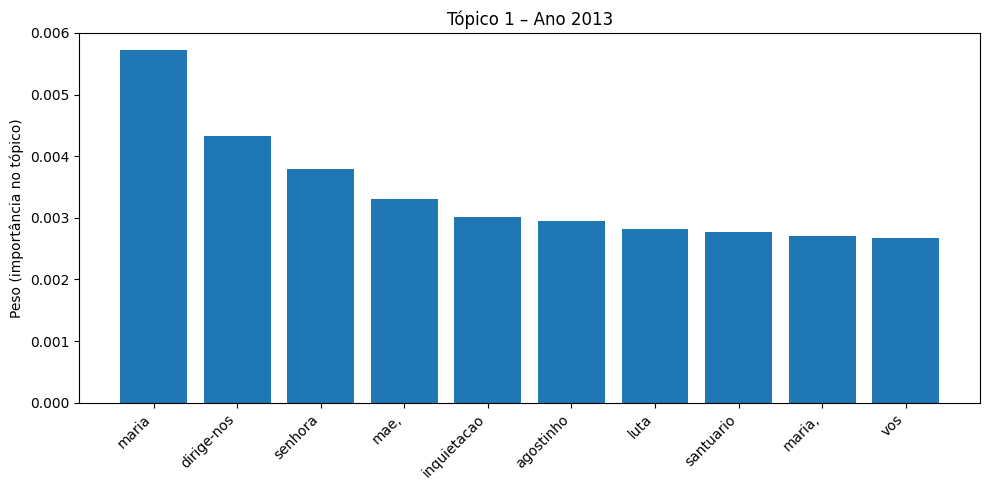

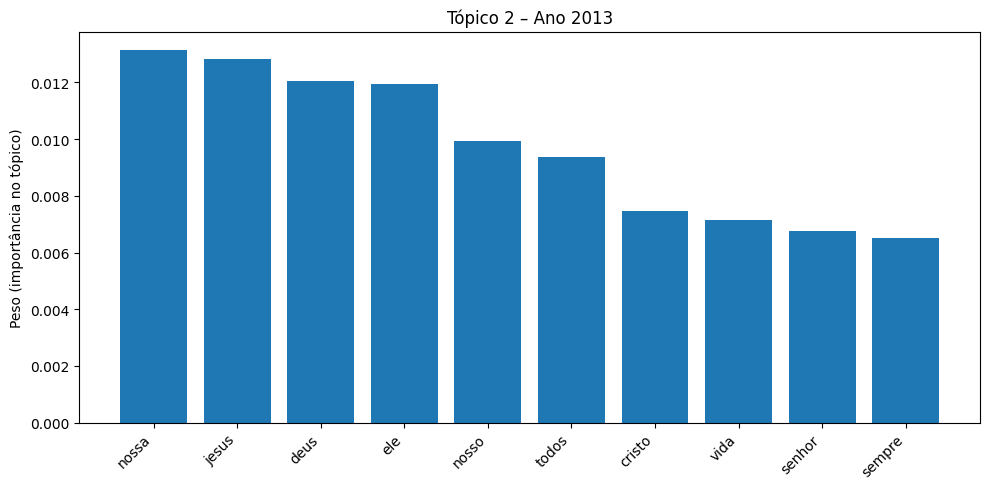

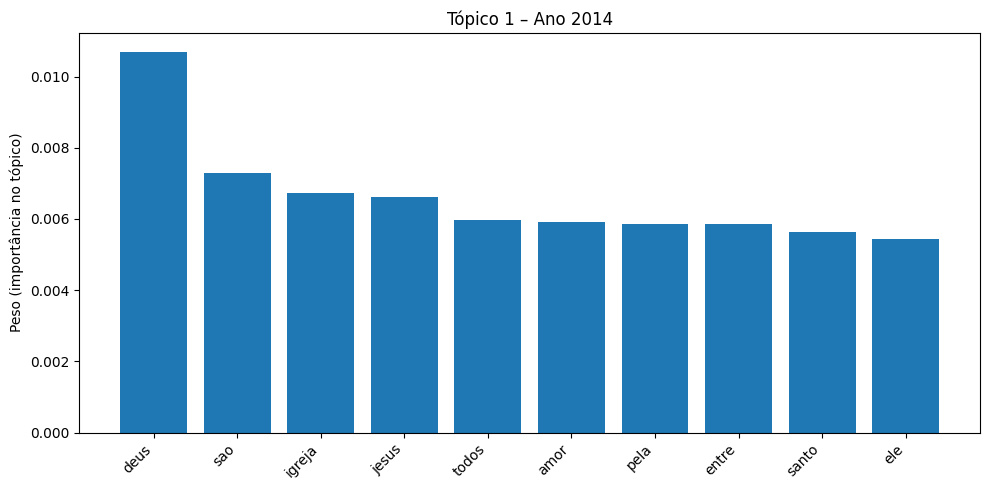

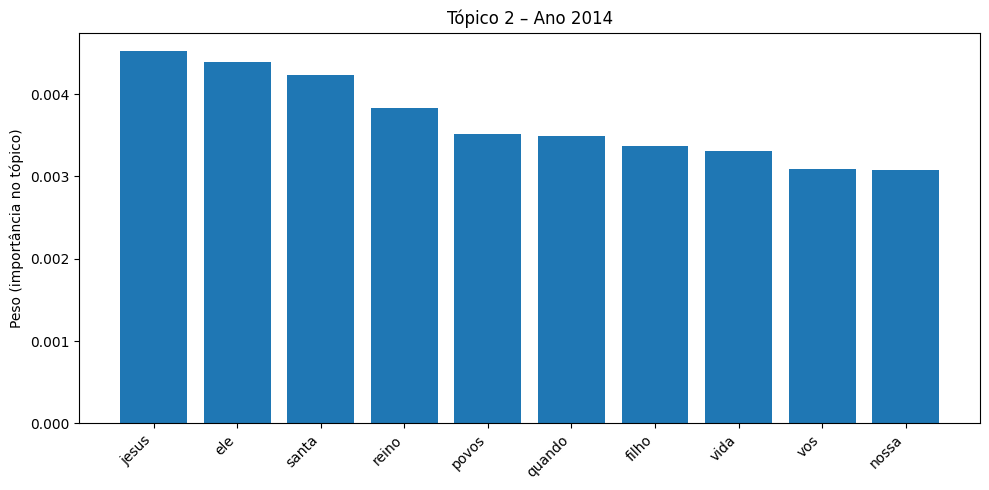

In [11]:
# Plotar gráficos com pesos reais dos tópicos
import matplotlib.pyplot as plt

for ano, topicos in topicos_por_ano.items():
    for nome_topico, termos_pesos in topicos.items():
        if isinstance(termos_pesos, list) and all(isinstance(tp, tuple) and len(tp) == 2 for tp in termos_pesos):
            termos, pesos = zip(*termos_pesos)

            plt.figure(figsize=(10, 5))
            plt.bar(termos, pesos)
            plt.title(f"{nome_topico} – Ano {ano}")
            plt.ylabel("Peso (importância no tópico)")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ Estrutura inesperada em {nome_topico} do ano {ano}")




- Importa bibliotecas Spark: Importa SparkSession do pyspark.sql e lit do pyspark.sql.functions (embora lit não pareça ser usado diretamente nesta célula, é uma função comum para trabalhar com DataFrames Spark).
- Cria ou obtém a SparkSession: spark = SparkSession.builder.getOrCreate() garante que haja uma sessão Spark ativa.
- Combina todas as homilias em um único DataFrame com o respectivo ano:
  - Cria uma lista vazia chamada linhas.
  - Itera sobre o dicionário textos_ano (que contém as homilias organizadas por ano).
  - Para cada ano e lista de textos naquele ano, itera sobre cada texto individual.
  - Cria uma tupla (ano, texto) para cada homilia e a adiciona à lista linhas.
  - Cria um DataFrame Spark chamado df_sql a partir da lista linhas, com as colunas "ano" e "texto".
- Cria uma visão temporária para consultas SQL:
  - df_sql.createOrReplaceTempView("homilias") cria uma "visão" temporária do DataFrame df_sql na memória do Spark.
  - Esta visão permite que você execute consultas SQL diretamente sobre os dados do DataFrame, referindo-se a ele pelo nome "homilias".
- Exemplo 1: Contar o número de homilias por ano:
  - Imprime um cabeçalho indicando o que a consulta fará.
  - Executa uma consulta SQL usando spark.sql() para selecionar o ano e contar o número de linhas (homilias) agrupadas por ano.
  - ORDER BY ano garante que os resultados sejam exibidos em ordem cronológica.
  - .show() exibe os resultados da consulta.
- Exemplo 2: Filtrar homilias que mencionam a palavra "esperança":
  - Imprime um cabeçalho indicando o que a consulta fará.
  - Executa uma consulta SQL para selecionar o ano e o texto das homilias.
  - WHERE LOWER(texto) LIKE '%esperanca%' filtra as homilias onde o texto (convertido para minúsculas) contém a palavra "esperanca".
  - LIMIT 10 restringe a saída para as primeiras 10 homilias encontradas.
  - .show(truncate=100) exibe os resultados, truncando a coluna de texto para 100 caracteres para uma melhor visualização.

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Criar ou obter a SparkSession
spark = SparkSession.builder.getOrCreate()

# Combinar todas as homilias em um único DataFrame com o respectivo ano
linhas = []
for ano, textos in textos_ano.items():
    for texto in textos:
        linhas.append((ano, texto))

df_sql = spark.createDataFrame(linhas, ["ano", "texto"])

# Criar uma visão temporária para consultas SQL
df_sql.createOrReplaceTempView("homilias")

# Exemplo 1: Contar o número de homilias por ano
print("📊 Número de homilias por ano:")
spark.sql("""
    SELECT ano, COUNT(*) AS qtd_homilias
    FROM homilias
    GROUP BY ano
    ORDER BY ano
""").show()

# Exemplo 2: Filtrar homilias que mencionam a palavra "esperança"
print("🔍 Homilias contendo a palavra 'esperança':")
spark.sql("""
    SELECT ano, texto
    FROM homilias
    WHERE LOWER(texto) LIKE '%esperanca%'
    LIMIT 10
""").show(truncate=100)


📊 Número de homilias por ano:
+----+------------+
| ano|qtd_homilias|
+----+------------+
|2013|          38|
|2014|          40|
+----+------------+

🔍 Homilias contendo a palavra 'esperança':
+----+----------------------------------------------------------------------------------------------------+
| ano|                                                                                               texto|
+----+----------------------------------------------------------------------------------------------------+
|2013|CELEBRACAO DAS PRIMEIRAS VESPERAS DA SOLENIDADE DE MARIA SANTISSIMA MAE DE DEUS E RECITACAO DO TE...|
|2013|CELEBRACAO DAS PRIMEIRAS VESPERAS DA SOLENIDADE DE MARIA SANTISSIMA MAE DE DEUS E RECITACAO DO TE...|
|2013|SANTA MISSA NA CONCLUSAO DO ANO DA FE NA SOLENIDADE DE NOSSO SENHOR JESUS CRISTO, REI DO UNIVERSO...|
|2013|SANTA MISSA NA CONCLUSAO DO ANO DA FE NA SOLENIDADE DE NOSSO SENHOR JESUS CRISTO, REI DO UNIVERSO...|
|2013|RITO DE ADMISSAO AO CATECUMENATO E ENCONTRO 